<a href="https://colab.research.google.com/github/A-Kester/csci-451/blob/main/docs/live-notebooks/04-more-gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Higher Dimensions

Working with models and gradients with many features

## Recap

[Last time](03-maximum-likelihood.qmd), we developed an end-to-end example of maximum-likelihood estimation for the 1-dimensional linear-Gaussian model, which allowed us to fit a regression line to data displaying a linear trend. We saw that we could use the gradient of the log-likelihood function (or in this case, equivalently, the mean-squared error) to iteratively update a guess for the optimal parameters using gradient descent.

The model we learned to fit had two parameters, $w_1$ and $w_0$. However, modern models have vastly more parameters, with frontier LLMs having parameter counts nearing the trillions. In order to reason about these models, we need to build fluency in reasoning about high-dimensional spaces of parameters. We turn to this now, with a focus on multivariate linear regression.

## Multivariate Linear-Gaussian Model

Recall that the 1-dimensional linear-Gaussian model assumed that the target variable $y$ was generated from a linear function of a single feature $x$ plus Gaussian noise. We can write this as:

$$
\begin{aligned}
    y_i \sim \mathcal{N}(w_1 x_i + w_0, \sigma^2)
\end{aligned}
$$

Suppose now that we have more than one predictive feature, which we would like to use in our model. Given $p$ features $x_1,\ldots,x_p$, we can extend the linear-Gaussian model to incorpoate all of them:

$$
\begin{aligned}
    y_i \sim \mathcal{N}(w_1 x_{i1} + w_2 x_{i2} + \cdots + w_p x_{ip} + w_0, \sigma^2) = \mathcal{N}\left(\sum_{j=1}^p w_j x_{ij} + w_0, \sigma^2\right)
\end{aligned}
 \qquad(1)$$

Here’s a visualization of a regression model with two features, $x_1$ and $x_2$, alongside the plane defined by the linear function of these features.

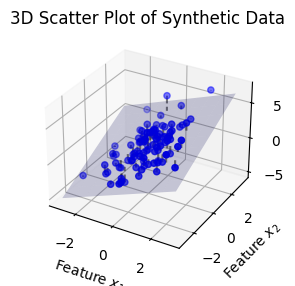

In [1]:
import torch
from matplotlib import pyplot as plt

# Generate synthetic data
torch.manual_seed(0)
n_samples = 100
X = torch.randn(n_samples, 2)
true_w = torch.tensor([1.0, 1.0])
true_b = 1.0
y = X @ true_w + true_b + 1 * torch.randn(n_samples)

# Plot the data
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), y.numpy(), c='b', marker='o')
ax.set_xlabel(r'Feature $x_1$')
ax.set_ylabel(r'Feature $x_2$')
ax.set_zlabel('Target y')
ax.set_title('3D Scatter Plot of Synthetic Data')

# plot the regression plane
xx1, xx2 = torch.meshgrid(torch.linspace(-3, 3, 10), torch.linspace(-3, 3, 10), indexing='ij')
zz = true_w[0] * xx1 + true_w[1] * xx2 + true_b
ax.plot_surface(xx1.numpy(), xx2.numpy(), zz.numpy(), alpha=0.2, color='b')

# plot the residuals
for i in range(n_samples):
    ax.plot([X[i, 0].item(), X[i, 0].item()],
            [X[i, 1].item(), X[i, 1].item()],
            [y[i].item(), (true_w @ X[i] + true_b).item()],
            c='black', alpha=0.5, linestyle='--')

plt.show()

In order to write down <a href="#eq-multivar-linear-gaussian-verbose" class="quarto-xref">Equation 1</a> more compactly, we need to introduce some notation. We’ll collect the features for data point $i$ into a vector:

$$
\begin{aligned}
    \mathbf{x}_i = (x_{i0}, x_{i1},x_{i2},\ldots,x_{ip})
\end{aligned}
$$

where we assume that $x_{i0} = 1$ is a constant feature included to capture the intercept term $w_0$. We also collect the parameters into a vector:

$$
\begin{aligned}
    \mathbf{w}= (w_0, w_1, w_2, \ldots, w_p)
\end{aligned}
$$

With this notation, we can rewrite the sum appearing in the mean of the Gaussian in <a href="#eq-multivar-linear-gaussian-verbose" class="quarto-xref">Equation 1</a> as an inner product between the feature vector $\mathbf{x}_i$ and the parameter vector $\mathbf{w}$: $ \mathbf{x}_i^T \mathbf{w} = \mathbf{x}_i \cdot \mathbf{w}= \langle \mathbf{x}_i,\mathbf{w} \rangle$

$$
\begin{aligned}
     \mathbf{x}_i^T \mathbf{w} =  \sum_{j=0}^p w_j x_{ij} = 1\cdot w_0 + \sum_{j=1}^p w_j x_{ij} = 1\cdot w_0 + \sum_{j=1}^p w_j x_{ij}\;.
\end{aligned}
 \qquad(2)$$

The choice of $x_{i0} = 1$ ensures that the intercept term $w_0$ is included in the inner product. This is so convenient that we’ll assume it from now on.

> **Assumption**
>
> From this point forwards, we assume that the feature vector $\mathbf{x}_i$ begins with a constant feature $x_{i0} = 1$.

This notation allows us to compactly rewrite the multivariate linear-Gaussian model as:

$$
\begin{aligned}
    y_i \sim \mathcal{N}( \mathbf{x}_i^T \mathbf{w}, \sigma^2)
\end{aligned}
$$

regardless of the number of features. We can make things even a bit simpler by defining a *score* $s_i$ associated to each data point $i$:

$$
\begin{aligned}
    s_i =  \mathbf{x}_i^T \mathbf{w}
\end{aligned}
 \qquad(3)$$

after which we can write: $$
\begin{aligned}
    y_i \sim \mathcal{N}(s_i, \sigma^2)
\end{aligned}
$$

### Log-Likelihood and Mean-Squared Error

The log-likelihood function of the multivariate linear-Gaussian model is given by

$$
\begin{aligned}
    \mathcal{L}(\mathbf{w}) &= \sum_{i=1}^n \log p_Y(y_i ; s_i, \sigma^2) \\
    &= \sum_{i=1}^n \log \left( \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(y_i - s_i)^2}{2 \sigma^2}\right) \right) \\
    &= -\frac{n}{2} \log(2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_{i=1}^n (y_i - s_i)^2\;,
\end{aligned}
$$

which, like last time, means that our maximum-likelihood estimation problem is equivalent to minimizing the mean-squared error between the observed targets $y_i$ and the scores $s_i$:

$$
\begin{aligned}
    R(\mathbf{x}, \mathbf{y}; \mathbf{w}) = \frac{1}{n} \sum_{i=1}^n (y_i - s_i)^2 = \frac{1}{n} \sum_{i=1}^n (y_i -  \mathbf{x}_i^T \mathbf{w})^2\;.
\end{aligned}
$$

In theory, we’re ready to start taking gradients and minimizing this function. However, it’s helpful to try to first simplify our notation *even more*, which we can do with the introduction of matrix and norm notation.

### Matrices and Norms

Recall that the *Euclidean norm* of a vector $\mathbf{v}\in \mathbb{R}^d$ is defined by the formula $\ell_p$

$$
\begin{aligned}
    \lVert \mathbf{v} \rVert^2 = \sum_{j=1}^d v_j^2\;.
\end{aligned}
$$

The norm notation allows us to eliminate the explicit summation in favor of vector operations:

$$
\begin{aligned}
    R(\mathbf{x}, \mathbf{y}; \mathbf{w}) = \frac{1}{n} \lVert \mathbf{y}- \mathbf{s} \rVert^2\;,
\end{aligned}
$$

where $\mathbf{s}$ is the vector of scores for all data points, whose $i$th entry is given by <a href="#eq-linear-score" class="quarto-xref">Equation 3</a>. Our last step is to give a compact formula for $\mathbf{s}$. To do this, we collect all of the feature vectors $\mathbf{x}_i$ into a matrix $\mathbf{X}\in \mathbb{R}^{n \times (p+1)}$, whose $i$th row is given by $\mathbf{x}_i^T$:

$$
\begin{aligned}
    \mathbf{X}= \left[\begin{matrix}
    - & \mathbf{x}_1^T & - \\
    - & \mathbf{x}_2^T & - \\
    & \vdots & \\
    - & \mathbf{x}_n^T & -
    \end{matrix}\right]\;.
\end{aligned}
$$

Now, if we multiply the matrix $\mathbf{X}$ by the parameter vector $\mathbf{w}$, we obtain

$$
\begin{aligned}
    \mathbf{X}\mathbf{w}= \left[\begin{matrix}
    - & \mathbf{x}_1^T & - \\
    - & \mathbf{x}_2^T & - \\
    & \vdots & \\
    - & \mathbf{x}_n^T & -
    \end{matrix}\right] \mathbf{w}= \left[\begin{matrix}
     \mathbf{x}_1^T \mathbf{w} \\
     \mathbf{x}_2^T \mathbf{w} \\
    \vdots \\
     \mathbf{x}_n^T \mathbf{w}
    \end{matrix}\right] =
    \left[\begin{matrix}
    s_1 \\
    s_2 \\
    \vdots \\
    s_n
    \end{matrix}\right] =
    \mathbf{s}\;,
\end{aligned}
$$

This gives us our compact formula for the MSE:

$$
\begin{aligned}
    R(\mathbf{x}, \mathbf{y}; \mathbf{w}) = \frac{1}{n}\lVert \mathbf{X}\mathbf{w}- \mathbf{y} \rVert^2\;.
\end{aligned}
 \qquad(4)$$

The maximum-likelihood problem for the multivariate linear-Gaussian model can therefore be written $\frac{1}{n}$

$$
\begin{aligned}
    \hat{\mathbf{w}} = \mathop{\mathrm{arg\,min}}_\mathbf{w}\lVert \mathbf{X}\mathbf{w}- \mathbf{y} \rVert^2\;.
\end{aligned}
 \qquad(5)$$

## Deriving and Checking Gradient Formulas

To solve the optimization problem in <a href="#eq-mse-optimization" class="quarto-xref">Equation 5</a>, we will need the gradient of $R$ with respect to $\mathbf{w}$. To do so, we’ll highlight two approaches.

### Entrywise Derivation

To compute the gradient of $R$ entrywise, we start by explicitly rewriting $R$ in summation notation, avoiding matrix and vector notation for the moment:

$$
\begin{aligned}
    R(\mathbf{x}, \mathbf{y}; \mathbf{w}) = \frac{1}{n} \sum_{i=1}^n (y_i -  \mathbf{x}_i^T \mathbf{w})^2 = \frac{1}{n} \sum_{i=1}^n (y_i - \sum_{j=0}^p w_j x_{ij})^2\;.
\end{aligned}
$$

We now take the derivative with respect to a particular parameter $w_k$:

$$
\begin{aligned}
    \frac{\partial R}{\partial w_k} &= \frac{\partial}{\partial w_k} \left( \frac{1}{n} \sum_{i=1}^n (y_i - \sum_{j=0}^p w_j x_{ij})^2 \right) \\
    &= \frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial w_k} \left(y_i - \sum_{j=0}^p w_j x_{ij}\right)^2 \\
    &= \frac{1}{n} \sum_{i=1}^n 2 \left(y_i - \sum_{j=0}^p w_j x_{ij}\right) \cdot \left(-x_{ik}\right) &\quad \text{(chain rule)}\\
    &= -\frac{2}{n} \sum_{i=1}^n x_{ik} \left(y_i -  \mathbf{x}_i^T \mathbf{w}\right) \\
    &= \frac{2}{n} \sum_{i=1}^n x_{ik} \left( \mathbf{x}_i^T \mathbf{w} - y_i\right)\;.
\end{aligned}
 \qquad(6)$$

### Vector Derivation

It’s more convenient and insightful to compute the gradient in vector form. This requires a few *gradient identities*, each of which can be derived and verified using entrywise methods like the one above. For our case, we need two identities $\mathbf{v}$

<span class="theorem-title">**Proposition 1 (Gradient of Norm Squared)**</span> For any $\mathbf{v}_0 \in \mathbb{R}^d$, if $f(\mathbf{v}) = \lVert \mathbf{v} \rVert^2$, then $$
\nabla f(\mathbf{v}_0) = 2 \mathbf{v}_0\;.
$$

<span class="theorem-title">**Proposition 2 (Compositions with Linear Maps)**</span> Let $f: \mathbb{R}^m \to \mathbb{R}$ be a differentiable function, and let $\mathbf{A}\in \mathbb{R}^{m \times n}$ be a matrix. Define $g: \mathbb{R}^n \to \mathbb{R}$ by $g(\mathbf{v}) = f(\mathbf{A}\mathbf{v})$. Then, for any $\mathbf{v}_0 \in \mathbb{R}^n$,

$$
\nabla g(\mathbf{v}_0) = \mathbf{A}^T \nabla f(\mathbf{A}\mathbf{v}_0)\;.
$$

If we apply these identities to <a href="#eq-mse-matrix-form" class="quarto-xref">Equation 4</a>, we obtain

$$
\begin{aligned}
    \nabla R(\mathbf{x}, \mathbf{y}; \mathbf{w}) = \nabla \left( \frac{1}{n} \lVert \mathbf{X}\mathbf{w}- \mathbf{y} \rVert^2 \right) &= \frac{1}{n} \nabla \lVert \mathbf{X}\mathbf{w}- \mathbf{y} \rVert^2 \\
    &= \frac{1}{n}\mathbf{X}^T \nabla \lVert \mathbf{X}\mathbf{w}- \mathbf{y} \rVert^2 &\quad \text{(Prop 3.2)}\\
    &= \frac{1}{n}\mathbf{X}^T \cdot 2(\mathbf{X}\mathbf{w}- \mathbf{y}) &\quad \text{(Prop 3.1)}\\
    &= \frac{2}{n} \mathbf{X}^T (\mathbf{X}\mathbf{w}- \mathbf{y})\;.
\end{aligned}
$$

It’s possible to check that this vector formula for the gradient matches the entrywise formula from <a href="#eq-mse-gradient-entrywise" class="quarto-xref">Equation 6</a> by verifying that the $k$th entry of the vector formula equals the entrywise formula for arbitrary $k$.

### Checking Vector Identities

How do we know that vector gradient identities like the ones we used above are correct? The most direct way is to verify them *entrywise*. To verify a vector identity entrywise, we just check that the $k$th entry of the left-hand side equals the $k$th entry of the right-hand side, for an arbitrary index $k$. For example, let’s verify the first identity above, $\nabla \lVert \mathbf{v} \rVert^2 = 2\mathbf{v}$. The $k$th entry of the left-hand side is given by the partial derivative with respect to entry $w_k$:

$$
\begin{aligned}
    \left(\nabla \lVert \mathbf{v} \rVert^2\right)_k = \frac{\partial}{\partial v_k} \lVert \mathbf{v} \rVert^2 = \frac{\partial}{\partial v_k} \sum_{j=1}^d v_j^2 =  \sum_{j=1}^d \frac{\partial}{\partial v_k} v_j^2 = \sum_{j=1}^d 2\delta_{jk}  v_k = 2 v_k\;,
\end{aligned}
$$

where $\delta_{jk}$ is the Kronecker delta, which equals 1 if $j=k$ and 0 otherwise. The $k$th entry of the right-hand side is simply $2 v_k$. Since these are equal for arbitrary $k$, the identity holds.

## Implementing Multivariate Regression

Our implementation for multivariate linear regression is very similar to our implementation for univariate regression from last time, and can actually be more compact in code thanks to our use of matrix operations. `torch` supplies the syntax `X@w` for matrix-vector and matrix-matrix multiplication, which we can use to compute the predictions for all data points at once.

### Object-Oriented API for Machine Learning Models

We are going to implement most of our machine learning models using an object-oriented approach which will generalize nicely once we move on to complex deep learning models.

#### Model Class

Under `torch`’s standard structure, a model is an instance of a `class` which holds parameters and implements a `forward` method which computes predictions given input data. Here’s a minimal implementation for linear regression:

In [3]:
class LinearRegression:
  # assuming: X already has a column of 1s
  def __init__(self, p):
    self.w = torch.zeros(p, 1) # initialize vector with p entries, 1 dimension

  def forward(self, X): # create the predictions
    #Xw (vector matrix multiplication), no broadcasting (need exactly # of weights as features in the data)
    return X@self.w

#### Loss Function

Alongside the model class, we need a loss function. While there are many possibilities, we’ll use our familiar mean-squared error. The loss function should accept predicted and true target values, and return a scalar loss value.

In [4]:
def mse(s, y):
  return torch.mean((s - y)**2)

#### Optimizer

The last thing we need is an *algorithm* for optimizing the parameters of the model. Gradient descent is one such algorithm. Here, we’ll implement a simple version of gradient descent as a separate class:

In [8]:
class GradientDescentOptimizer:

  def __init__(self, model, lr=1e-2): # model and learning rate (lr = 1/100)
    self.model = model
    self.lr    = lr

  def step(self, X, y):
    self.model.w -= self.lr * self.grad_func(X, y) # update w vector, gradient descent update

  def grad_func(self, X, y):  # gradient with p entries (p is length of weight vector w)
    n = y.shape[0] # length of y
    return 2/n * X.T @ (X@self.model.w - y) # X.T --> X transpose

Now we’re ready to run multivariate linear regression. Let’s generate some random synthetic data for testing.

In [6]:
# Generate synthetic data
torch.manual_seed(0)
n_samples = 100
n_features = 5
X = torch.randn(n_samples, n_features)
X = torch.cat([torch.ones(n_samples, 1), X], dim=1) # shape (n_samples, n_features + 1)
true_w = torch.randn(n_features + 1, 1)

signal = X @ true_w
noise = 0.5 * torch.randn(n_samples, 1)
y = signal + noise

With this data, we can check that our vector gradient formula matches the entrywise formula we derived earlier, which we can do via torch’s automatic differentiation:

In [ ]:
# TODO - checking gradient is right

print(torch.allclose(grad_manual, model.w.grad))  # Should print True

Looks fine! Now that we have gradient descent implemented, we can consider the gradient descent algorithm itself. This time, we’ll implement gradient descent as two functions: one which performs a single step of gradient descent, and one which handles the main loop, including storing values of the loss and checking for convergence. $\lVert \mathbf{w}_\mathrm{new} - \mathbf{w}_\mathrm{old} \rVert$

In [9]:
# Training Loop

model = LinearRegression(p = 6)
opt = GradientDescentOptimizer(model)

loss_history = [] # to watch MSE go down over time

for _ in range(1000): # check notes for convergence criterion to do less than 1000 loops
  s = model.forward(X)
  loss = mse(s, y)
  loss_history.append(loss.item())

  opt.step(X, y) # one round of gradient descent

1.  Initialize a list to store the loss history.
2.  Compute and store the current loss.
3.  Perform a single gradient descent step.
4.  Check for convergence by seeing if the change in parameters is small.

Now we’re ready to run gradient descent.

Figure 1: Loss vs. iteration during gradient descent for our manual implementation of multivariate linear regression.

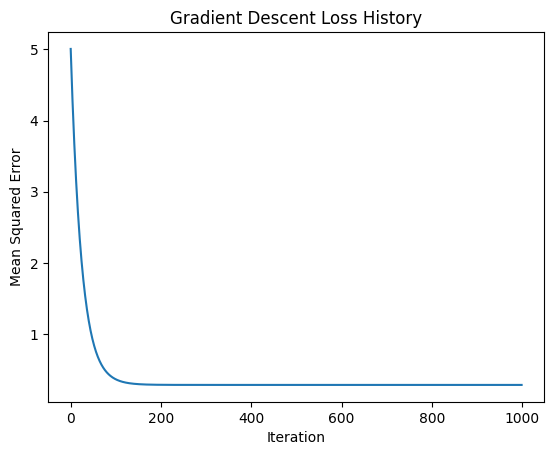

In [10]:
# Plot loss history
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Gradient Descent Loss History')
plt.show()

This time, because we implemented a convergence check, our main loop terminated automatically.

We can compare the learned parameters to the true parameters:

In [11]:
print("Learned parameters:\n", model.w.flatten())
print("True parameters:\n", true_w.flatten())

Learned parameters:
 tensor([ 0.8669,  0.3118,  0.2477,  1.0595, -0.9777, -1.2764])
True parameters:
 tensor([ 0.8393,  0.2479,  0.2067,  0.9928, -0.8986, -1.2028])


The learned parameters are relatively close to the true parameters we planted in the synthetic data.